<a href="https://colab.research.google.com/github/Qukoyk/oddball/blob/master/CV_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERP Online Analysis Platform

Students will have a class named "Laboratory Work in Psychology A" in their junior year, learning how to record erp(event-related potential) and do data analysis. Every year we use a Matlab script which was written years ago. This year, we upgraded Matlab to 2019 version and the script didn't work anymore. Since professor was very busy and no one know much about matlab, I wrote some small scipts in python3 to instead the old one.   
This script could find out where the trigger is. 200ms before the trigger and 1000ms after the trigger will be took out and showed as figures. Students are asked to find out which figure(trial) was not good enough or should be droped out. The final figure will be created in excel.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
分析したいチャンネルの番号を入力ください：
1

チャンネルデータ読み込み中……
読み込み完成

フィルターリング開始
フィルターリング済み

トリガー抽出開始……

全トリガーが 65 個検出された

これからトリガー前後の波形を表示
1


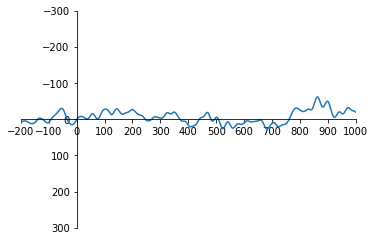

2


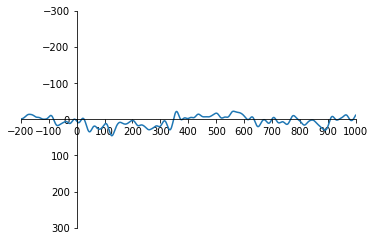

3


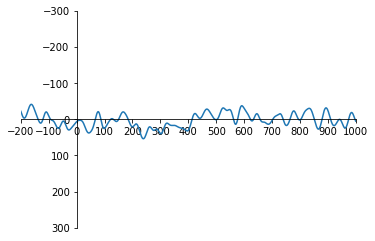

4


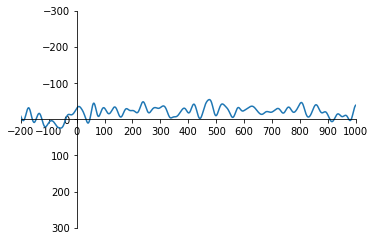

5


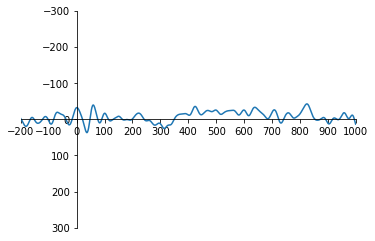

6


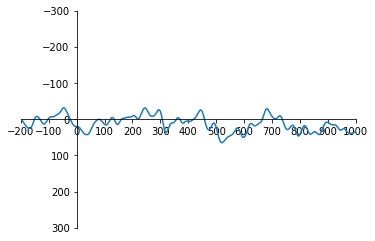

7


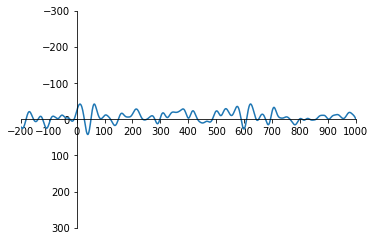

8


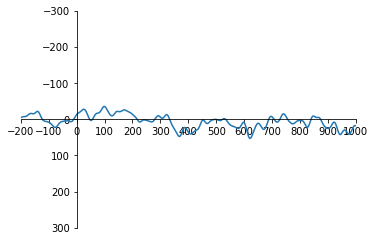

9


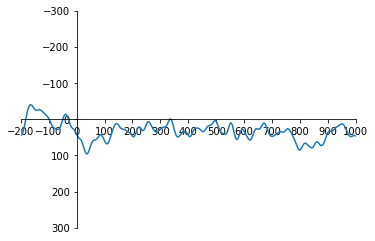

10


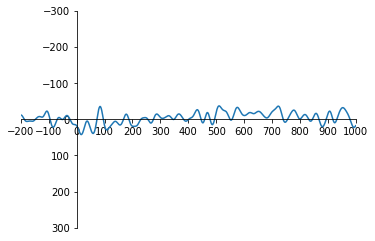

11


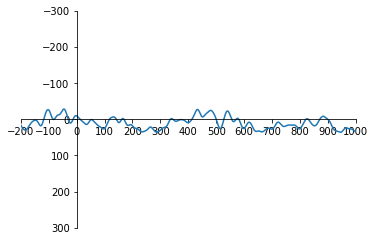

12


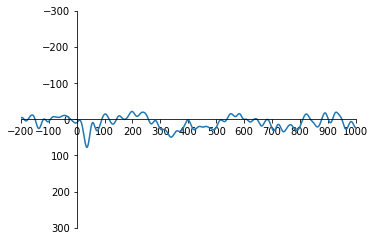

13


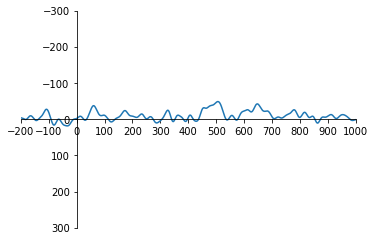

14


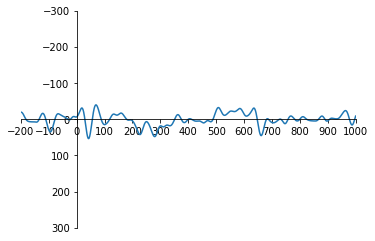

15


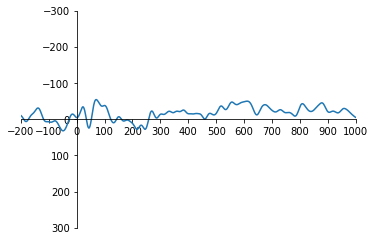

16


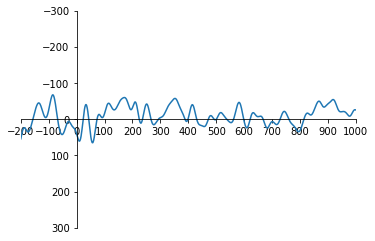

17


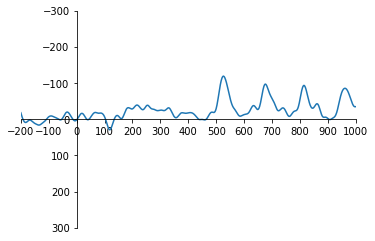

18


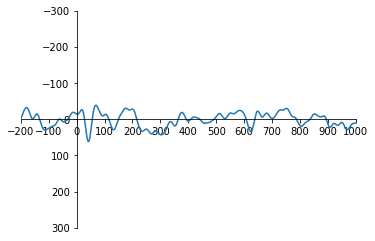

19


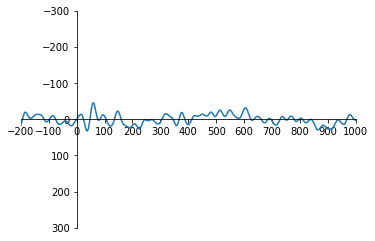

20


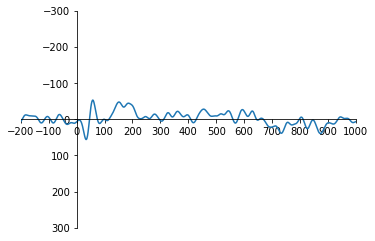

21


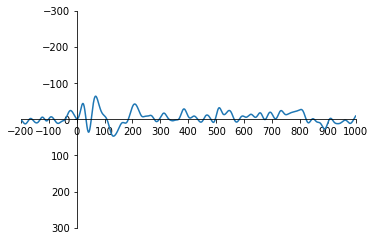

22


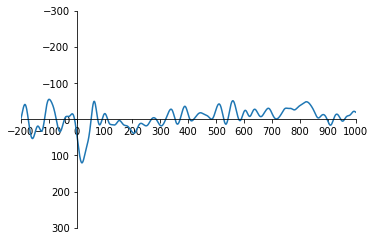

23


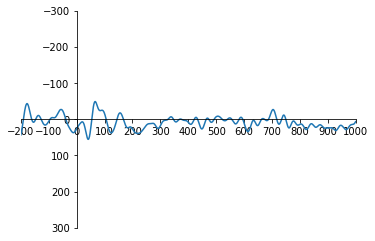

24


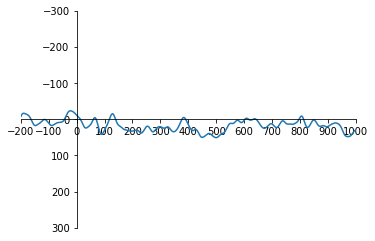

25


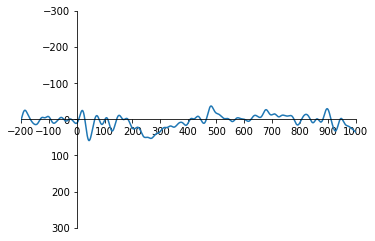

26


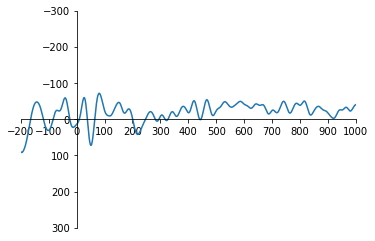

27


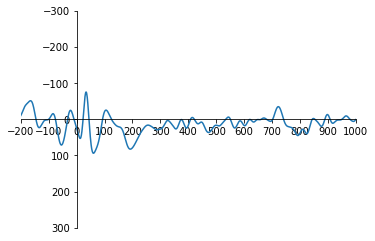

28


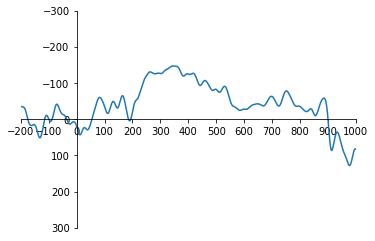

29


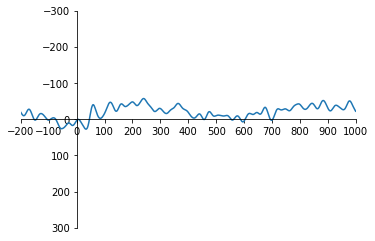

30


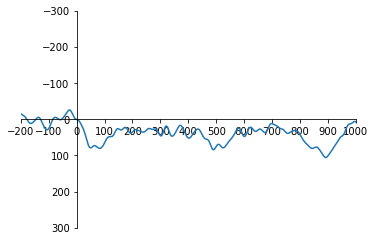

31


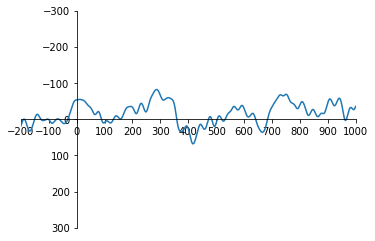

32


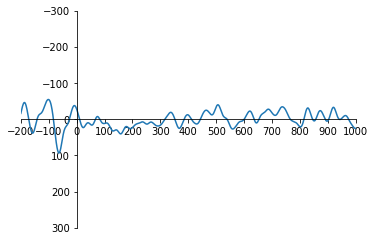

33


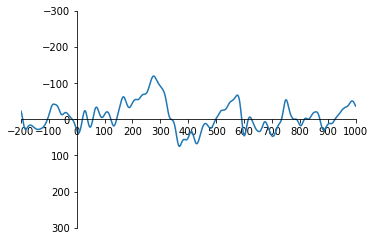

34


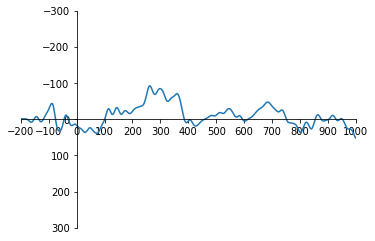

35


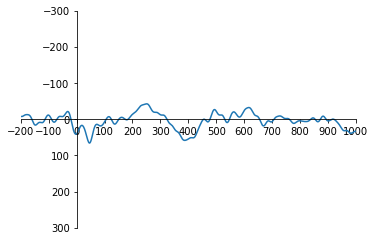

36


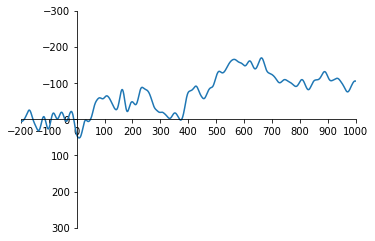

37


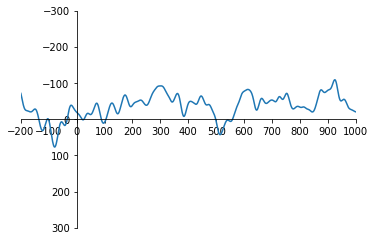

38


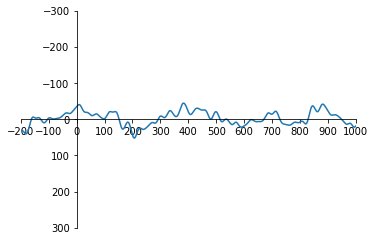

39


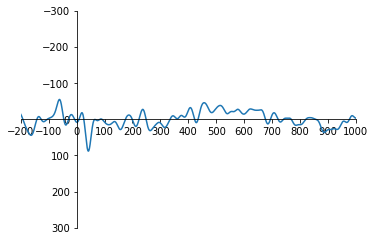

40


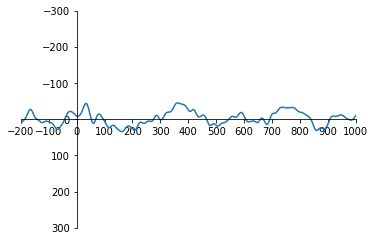

41


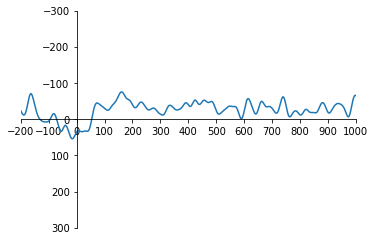

42


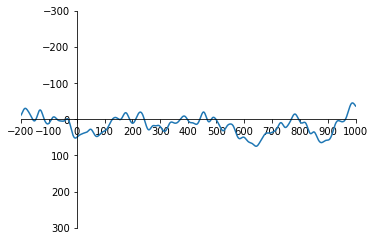

43


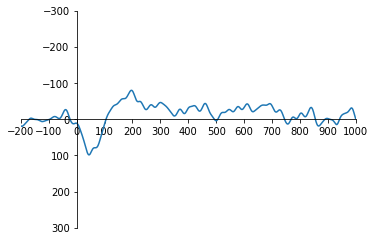

44


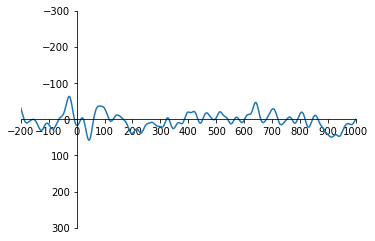

45


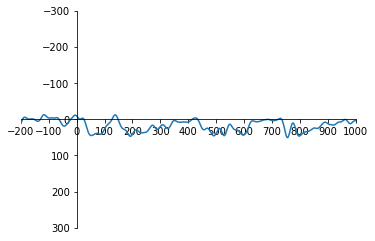

46


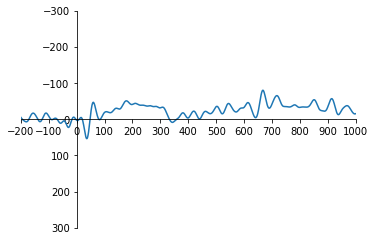

47


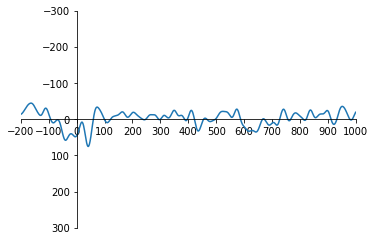

48


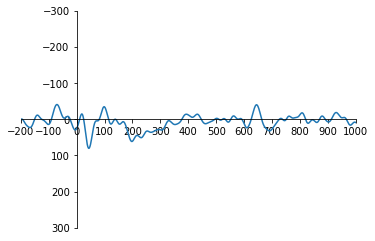

49


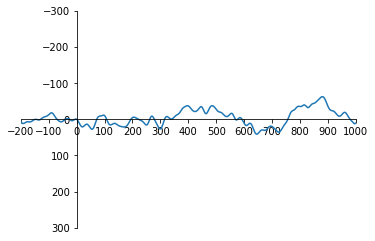

50


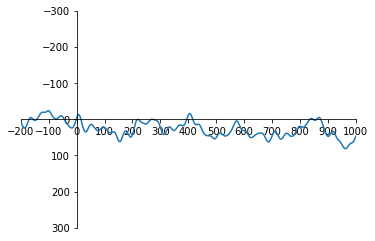

51


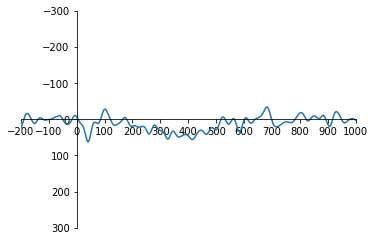

52


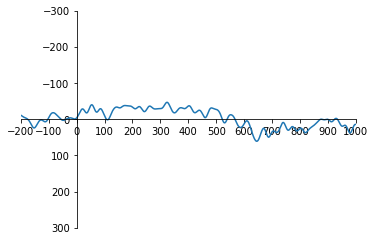

53


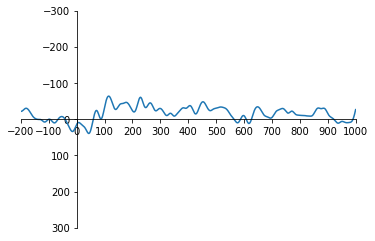

54


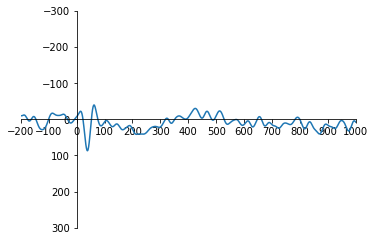

55


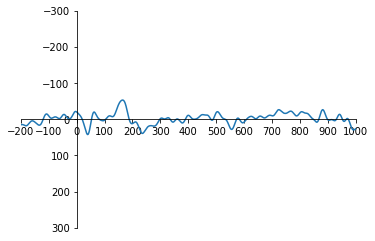

56


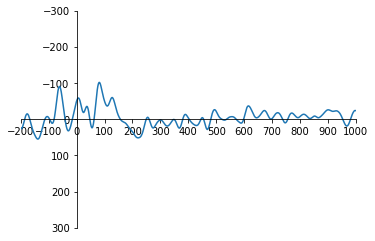

57


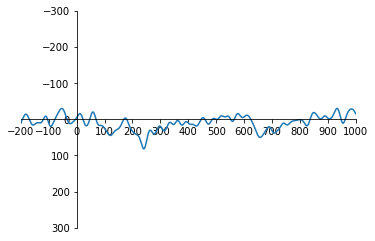

58


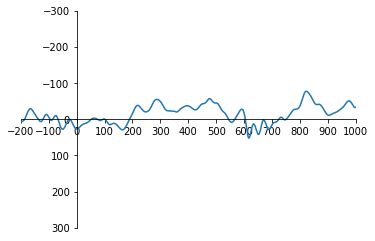

59


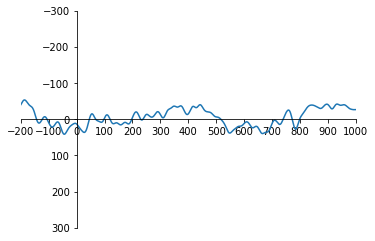

60


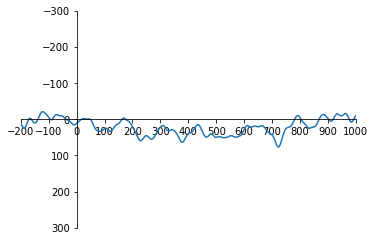

61


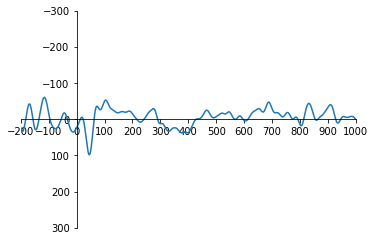

62


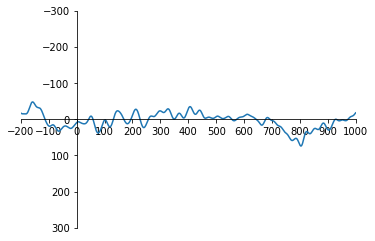

63


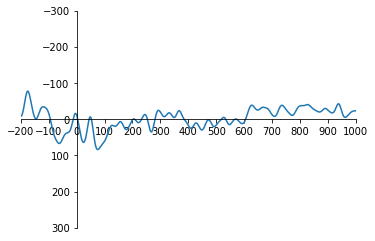

64


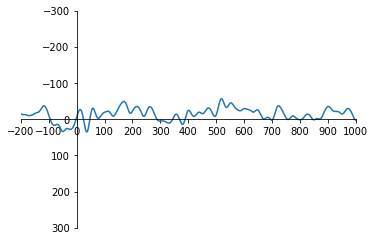

65


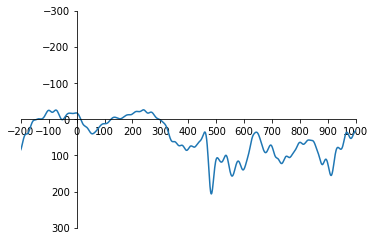

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
 
'''
 
実験A_2021.py
 
 
2021年度 広島大学総科行動系「心理学実験A」
聴覚誘発電位データ分析用プログラム
 
・試行ごと表示　ON
・外れ値自動除外　OFF
・強制選択試行　含み
・キャリブレーション校正　含み
・ChebyshevⅠ型フィルター　ON
・Detrendフィルター　ON
 
 
Created by: Ruoheng "Qukoyk" Qu
            2021/06/01
 
'''
 
 
# import文
import numpy as np
import matplotlib.pyplot as plt
import time
import csv,os
from scipy import signal
# from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
 
 
# 定数宣言
waveMax = 301 # 外れ値とする
waveMin = -300
figMax = waveMax # 外れ値視察除外の時
figMin = waveMin
# figMax = 131 # 外れ値自動除外の時
# figMin = -130
drive.mount('/content/drive')
 
# path = "/content/drive/My Drive" # 教示用
path = "/content/drive/My Drive/実験A_2021" # 自機用
 
os.chdir(path)
 
# 変数宣言
# fileName = 'ozaki10-1_data.m00 のコピー' # 教示用
fileName = 'ozaki10-1_data.m00' # 自機用
position = 0
positionList = []
 
 
# トリガーのチャンネルを宣言
trg = 8
 
# 番号入力
chAnswer = input("分析したいチャンネルの番号を入力ください：\n")
print('\n'+"チャンネルデータ読み込み中……")
 
 
# 分析するチャンネルを読み込む
chList = []
chList0 = np.loadtxt(fileName, skiprows=2, usecols=int(chAnswer)-1)
print("読み込み完成")
 
print('\n'+"フィルターリング開始")
 
# Calibration
calCoef = 1.09049 # 校正係数
for i in chList0:
    chList.append(i/calCoef)
    pass
 
# バンドパス Chebyshev Ⅰ型　リップル1db（第一種チェビシェフフィルタ）
# フィルターパラメータ設定
highPass = 0.5 # Hz
lowPass = 50 # Hz
sFreq = 1000 # Hz
b, a = signal.cheby1(2,1,[highPass/sFreq, lowPass/sFreq],btype='bandpass')
chList = signal.filtfilt(b, a, chList)
# トレンド除去
chList = signal.detrend(chList)
print("フィルターリング済み")
 
 
# 関数 
# トリガー抽出関数
def triggerExtract(trigger):
    # 関数内変数を宣言
    counter = 0
    continuous = False
    position = 0
    tempPosition = 0
    triggerList = []
    tempList = np.loadtxt(fileName,skiprows=2, usecols=trigger-1)
    tempTriggerList = []
    # トリガー波形整形・二極化（測定の時トリガーチャンネルの感度の設定が怪しかったから）
    for i in tempList:
        if i > 500000:
            tempTriggerList.append(1)
            pass
        else:
            tempTriggerList.append(0)
            pass
        pass
 
    # test
    aList = []
    tempi = tempTriggerList[0]
    # 「 < 」 は「_┌─」、「 > 」は「─┐__」
    for i in tempTriggerList:
        if tempi < i:
            aList.append(1)
        else:
            aList.append(0)
        tempi = i
 
    # 抽出開始
    for i in aList:
        if i == 0:
            continuous = False
            pass
        if i == 1 and continuous == False:
            if position - tempPosition > 15000: # 今回のトリガーは1200msではないため経験値を選出
                counter = counter + 1
                # triggerList.append(position+30000) # 消音時がトリガーとする
                triggerList.append(position)
                continuous = True
                tempPosition = position
                pass
            pass
        # 累進
        position = position + 1
        pass
 
    print('\n'+"全トリガーが",counter,"個検出された")
 
    return triggerList
 
# 外れ値検出関数
def triggerCheck(listName):
    # 局所変数設定
    position = 0
    badList = []
    tempList = []
    tempList1 = []
    trialList = []
    sessionList = []
 
    # 検出開始
    for i in listName:                     # i はトリガーの時点
 
        for j in range(i-200,i+1001):      # j はトリガーの時点前200ms~後1000msの時点
            k = chList[j]                  # k はj時点の脳波の値
            if k>waveMax or k<waveMin:
                tempList.append(position)  # k値は過大か過小ならこのトリガーを記録
                pass
            tempList1.append(k)            # tempList1は波形そのもの，つまり無修正なやつ
            pass
 
        # ベースライン（-200ms間を平均）
        baseLine = np.mean(tempList1[0:200])
        # トライアルリストのデータ（1トリガー前後1200ms間のデータ）とベースラインの差をセッションリストに導入
        for l in tempList1:
            trialList.append(l-baseLine)
            pass
        sessionList.append(trialList)
        # トライアルリストを初期化
        tempList1 = []
        trialList = []
        # ポジションのカウンターを累進
        position = position + 1
        pass
 
    # 重複要素を削除
    tempList = list(set(tempList))
    # ソーティング
    tempList.sort()
    # 辞書化
    m = {i:element for i, element in enumerate(sessionList)}
    # 外れ値除外
    # [m.pop(i) for i in tempList]
    # リストに戻す
    sessionList = list(m.values())
    # 「012345」から「123456」に変換
    for i in tempList:
        i = i + 1
        badList.append(i)
        pass
    # print('\n'+"外れるトリガーは",'\n',badList)
    # print("計",len(badList),"個")
    return sessionList
 
 
# メインプログラム
# トリガー抽出
print('\n'+"トリガー抽出開始……")
trgList = triggerExtract(trg)
# 外れ値検出 & データ行列化
trgArray = np.array(triggerCheck(trgList))
 
 
# 保存
np.savetxt(str(chAnswer)+'ch.csv',trgArray.T,delimiter=',')
 
# 加算平均
#trgMean = np.mean(trgArray,axis=0)
 
# グラフ作成
print('\n'+"これからトリガー前後の波形を表示")
position = 0
for i in trgArray:
    # 軸調整
    # デフォルトの書式なら、グラフの周囲に枠がある。
    # そして、グラフの中に横軸と縦軸はない。
    # なぜというと「枠」は軸そのものである。
    # ここは上と右の枠線を不可視化になってから
    # 左と下の枠をデータが「0」のところに移動する
    ax = plt.gca()
    # 数字を軸の傍に表したいなら
    ax.spines['right'].set_color('none')         
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    # # 数字をグラフの縁側に表したいなら
    # ax.spines['left'].set_color('none')
    # ax.spines['bottom'].set_color('none')
    # ax.xaxis.set_ticks_position('bottom')
    # ax.spines['top'].set_position(('data',0))
    # ax.yaxis.set_ticks_position('left')
    # ax.spines['right'].set_position(('data',0))
    # 縦軸の反転
    ax.invert_yaxis()
    # 横軸の範囲設定
    x = np.arange(-200,1001)
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200,1001,100))
    plt.ylim(figMax,figMin)
    plt.yticks(np.arange(figMin,figMax,100))
    # plt.xlabel("Time after stimulus (ms)")
    # plt.ylabel("Potential (μV)")
    plt.plot(x,i)
    position = position + 1
    print(position)
    plt.show()
    pass